# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gdown 'https://drive.google.com/uc?id=16wOWz_yT6Qgu3TloHnzKmVIVmO9-tE7J'

In [ ]:
!unzip APDrawingDB.zip

# Data

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import os
import random
import sys

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image

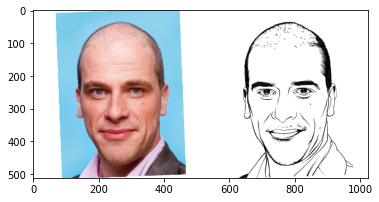

In [2]:
img = image.load_img("/content/APDrawingDB/data/train/img_1586-r1.png")
plt.imshow(img)

In [3]:
from tensorflow.keras.utils import Sequence

class DataGenerator2D(Sequence):
    def __init__(self, base_path, img_size=256, batch_size=1, shuffle=True):
        self.base_path = base_path
        self.img_size = img_size
        self.id = os.listdir(base_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.ceil(len(self.id)/float(self.batch_size)))

    def __load__(self, id_name):
        image_path  = os.path.join(self.base_path, id_name)

        img = cv2.imread(image_path, 1)  # reading image in RGB format

        height, width, colour = img.shape
        # Cut the image in half
        width_cutoff = width // 2
        image = img[:, :width_cutoff]
        sketch = img[:, width_cutoff:]

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sketch = cv2.cvtColor(sketch, cv2.COLOR_BGR2GRAY)

        image = cv2.resize(image, (self.img_size, self.img_size))
        sketch = cv2.resize(sketch, (self.img_size, self.img_size))

        # Normalizing the image
        image = image/255.0
        sketch = sketch/255.0

        return image, sketch


    def __getitem__(self, index):
        if (index+1)*self.batch_size > len(self.id):
            file_batch = self.id[index*self.batch_size:]
        else:
            file_batch = self.id[index*self.batch_size:(index+1)*self.batch_size]
        
        images, sketches = [], []

        for id_name in file_batch:
            _img, _sketch = self.__load__(id_name)
            images.append(_img)
            sketches.append(_sketch)

        images = np.array(images)
        sketches  = np.array(sketches)

        return images, sketches


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.id))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [4]:
train_generator = DataGenerator2D('/content/APDrawingDB/data/train', img_size=256, batch_size=8, shuffle=True)
val_generator = DataGenerator2D('/content/APDrawingDB/data/test', img_size=256, batch_size=8, shuffle=False)

In [5]:
# Test the generator

X, y= val_generator.__getitem__(0)
print(X.shape, y.shape)

X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256)
(8, 256, 256, 3) (8, 256, 256)


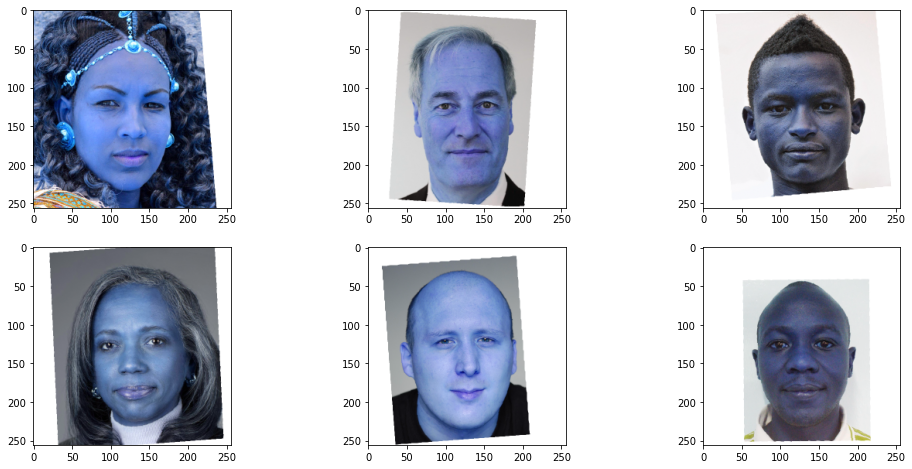

In [6]:
fig=plt.figure(figsize=(17, 8))
columns = 3
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

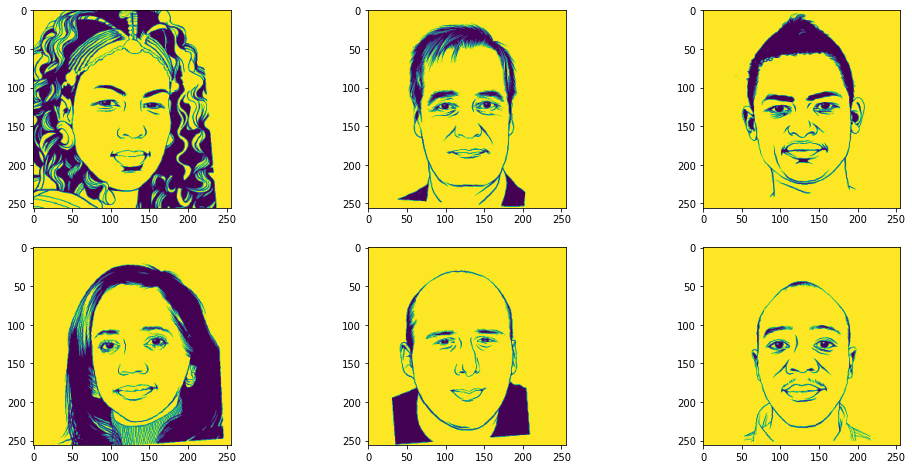

In [7]:
fig=plt.figure(figsize=(17, 8))
columns = 3
rows = 2
for i in range(1, columns*rows + 1):
    img = y[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Model

In [8]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    layers.append(x)
    x = MaxPooling2D() (x)
    x = BatchNormalization()(x)
    f = f*2
  ff2 = 64
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = BatchNormalization()(x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = BatchNormalization()(x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = BatchNormalization()(x)
  # outputs = Conv2D(3, 1, activation='sigmoid') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [10]:
# COMPILING MODEL

model = unet()

opt = tf.keras.optimizers.Adam(0.0003)
metrics = ["acc"]

model.compile(loss=dice_coef_loss, 
              optimizer=opt, 
              metrics=metrics)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
history = model.fit_generator(
                    generator=train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=420//8,
                    validation_steps=70//8,
                    epochs = 20)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
52/52 [==============================] - 172s 3s/step - loss: 0.1557 - acc: 0.6637 - val_loss: 0.1857 - val_acc: 0.7062
Epoch 2/20
52/52 [==============================] - 169s 3s/step - loss: 0.0907 - acc: 0.7678 - val_loss: 0.1480 - val_acc: 0.7104
Epoch 3/20
52/52 [==============================] - 170s 3s/step - loss: 0.0685 - acc: 0.7940 - val_loss: 0.1039 - val_acc: 0.7629
Epoch 4/20
52/52 [==============================] - 176s 3s/step - loss: 0.0549 - acc: 0.8090 - val_loss: 0.1064 - val_acc: 0.7250
Epoch 5/20
52/52 [==============================] - 169s 3s/step - loss: 0.0462 - acc: 0.8183 - val_loss: 0.0937 - val_acc: 0.7432
Epoch 6/20
52/52 [==============================] - 170s 3s/step - loss: 0.0396 - acc: 0.8234 - val_loss: 0.0763 - val_acc: 0.7693
Epoch 7/20
52/52 [==============================] - 169s 3s/step - loss: 0.0355 - acc: 0.8272 - val_loss: 0.0736 - val_acc: 0.7769
Epoch 8

In [12]:
model.save("/content/drive/MyDrive/models/ImageSketching/model20.hdf5")

In [13]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


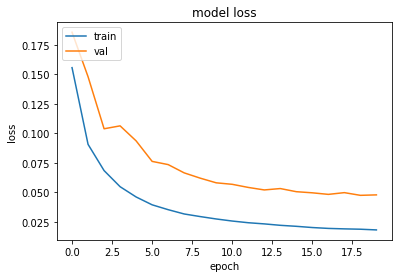

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

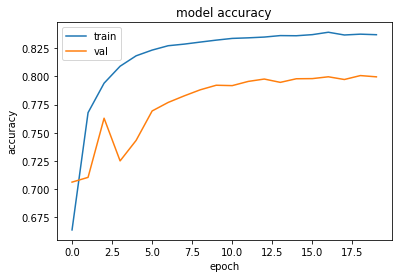

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
X, y = val_generator.__getitem__(1)
print(X.shape, y.shape)

(8, 256, 256, 3) (8, 256, 256)


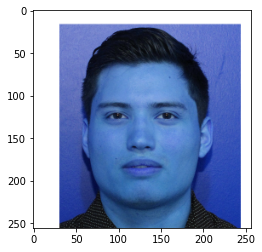

In [17]:
plt.imshow(X[2])

In [18]:
predict = model.predict(X)
predict.shape

(8, 256, 256, 1)

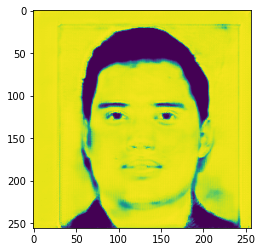

In [22]:
# img = cv2.cvtColor(predict[2], cv2.COLOR_GRAY2BGR)
img = predict[2]
img = cv2.resize(img, (256, 256))
cv2.imwrite("img.jpg", img)
plt.imshow(img)